
This notebook uses the output of the rule
--- 20_preprocessing.smk::merge_all_readcov_seqclass
--- 20_preprocessing.smk::prep_t2t_seq_class_cache_file
as input, and produces a panel for figure depicting the
relative read coverage (HiFi and ONT) in the Y sequence class
regions using the input read coverage as anchor point

Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/coverage
Working directory:  /home/local/work/data/sig_chrY/paper
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


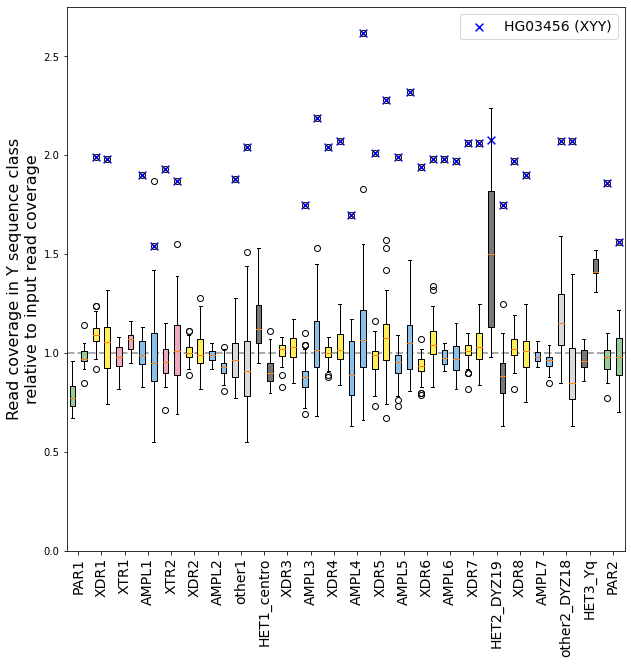

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import pathlib as pl
import collections as col
import re as re

import matplotlib as mplt
import matplotlib.pyplot as plt

desc="""
This notebook uses the output of the rule
--- 20_preprocessing.smk::merge_all_readcov_seqclass
--- 20_preprocessing.smk::prep_t2t_seq_class_cache_file
as input, and produces a panel for figure depicting the
relative read coverage (HiFi and ONT) in the Y sequence class
regions using the input read coverage as anchor point
"""

save_plots = True

print(desc)

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper')
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

t2t_file = wd_dir / pl.Path('annotation_tables', 'T2T.chrY-seq-classes.tsv')
t2t = pd.read_csv(t2t_file, sep='\t', header=0)
region_to_idx = dict((row.name, row.Index) for row in t2t.itertuples())

stats_file = wd_dir / pl.Path('rd_cov', 'SAMPLES.HIFIRW.ONTUL.na.chrY.read-cov-seqclass.tsv')
stats = pd.read_csv(stats_file, sep='\t', header=0, comment='#')
stats['pos_idx'] = stats['seqclass'].replace(region_to_idx)

hifi_boxes = []
ont_boxes = []
data_points = []
for read_type, merged_data in stats.groupby('reads'):
    for seqclass, stat_data in merged_data.groupby('seqclass')[['rel_mean_cov', 'pos_idx']]:
        idx = stat_data.at[stat_data.index[0], 'pos_idx']
        if read_type == 'HIFI':
            data_points.append((idx, seqclass, stat_data.shape[0]))
            hifi_boxes.append((idx, stat_data['rel_mean_cov'].values))
        elif read_type == 'ONT':
            ont_boxes.append((idx, stat_data['rel_mean_cov'].values))
        else:
            raise

fig, ax = plt.subplots(figsize=(10,10))
fig_name = 'panel_readcov_per_seqclass'

hifi_pos = np.arange(0, len(hifi_boxes) * 2, 2)
hifi_box = ax.boxplot(
    [t[1] for t in sorted(hifi_boxes)],
    positions=hifi_pos,
    patch_artist=True,
)

ont_pos = np.arange(1, len(ont_boxes) * 2 + 1, 2)
ont_box = ax.boxplot(
    [t[1] for t in sorted(ont_boxes)],
    positions=ont_pos,
    patch_artist=True,
)

x_tick_pos = hifi_pos + 0.5

ax.set_xticks(x_tick_pos)
ax.set_xticklabels([t[1] for t in sorted(data_points)], rotation=90, fontsize=14)

for hbox, obox, row in zip(hifi_box['boxes'], ont_box['boxes'], t2t.itertuples()):
    hbox.set_facecolor((row.red,row.green,row.blue))
    obox.set_facecolor((row.red,row.green,row.blue))

ax.axhline(1, 0, 1, color='darkgrey', ls='dashed', lw=2, zorder=0)

ax.set_ylim(0, 2.75)

xyy_sample = 'HG03456'

xyy_scatter_x = []
xyy_scatter_y = []
for row in stats.loc[stats['sample'] == xyy_sample, :].itertuples():
    if row.reads == 'HIFI':
        x_pos = hifi_pos[row.pos_idx]
    elif row.reads == 'ONT':
        x_pos = ont_pos[row.pos_idx]
    else:
        raise
    y_pos = row.rel_mean_cov
    xyy_scatter_x.append(x_pos)
    xyy_scatter_y.append(y_pos)
    
ax.scatter(
    xyy_scatter_x,
    xyy_scatter_y,
    marker='x',
    s=60,
    c='blue',
    label='HG03456 (XYY)'
)

ax.legend(loc='best', fontsize=14)
ax.set_ylabel(
    'Read coverage in Y sequence class\nrelative to input read coverage',
    fontsize=16
)

if save_plots:
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.png'),
        dpi=150, bbox_inches='tight', transparent=None,
        bbox_extra_artists=[], facecolor="w"
    )
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.pdf'),
        bbox_inches='tight', transparent=None,
        bbox_extra_artists=[], facecolor="w"
    )
